In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# print utilities

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Data understanding

In [5]:
input_dir = './data/'
df = pd.read_csv(input_dir + 'train.tsv.zip', sep='\t')

df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Each Sentence has been parsed into many phrases by the Stanford parser
* each phrase has a **PhraseId**
* each sentence has a **SentenceId**

Each phrase is associated to a **Sentiment** label:
* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

## Phrase examples

Let's see an example of phrase for each of the possible sentiment labels

In [9]:
sentiments_map = {
    0: 'negative',
    1: 'somewhat negative',
    2: 'neutral',
    3: 'somewhat positive',
    4: 'positive'
}

for sentiment in sentiments_map.keys():
    print(f'{color.BOLD}{sentiments_map[sentiment]}{color.END} example:\
          \n{df.loc[df.Sentiment == sentiment].Phrase.iloc[0]}\n')

negative example:          
would have a hard time sitting through this one

somewhat negative example:          
A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .

neutral example:          
A series of escapades demonstrating the adage that what is good for the goose

somewhat positive example:          
good for the goose

positive example:          
This quiet , introspective and entertaining independent is worth seeking .



## What are the most common sentiments?

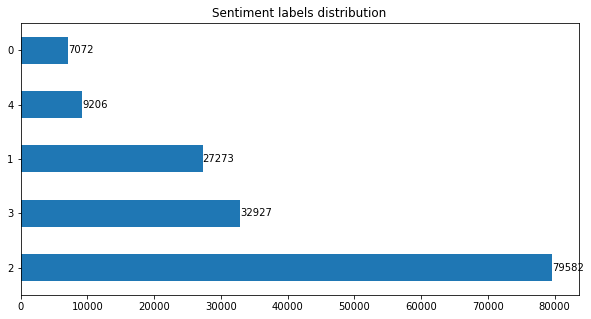

In [5]:
ax = (df.Sentiment.value_counts().plot(kind='barh', figsize=(10, 5)))

ax.set_title('Sentiment labels distribution')
ax.bar_label(ax.containers[0], label_type='edge')

plt.show()

The most frequent sentiment is **neutral**!

## Sentences and Phrases relationship
### How many phrases are there in each sentence?

In [6]:
print (f'On average: {df.groupby(df.SentenceId).PhraseId.count().mean()}')

On average: 18.297572986282095


### Different sentiments in the same sentence!!

In [8]:
df.groupby(df.SentenceId).Sentiment.nunique()

SentenceId
1       3
2       3
3       4
4       4
5       3
       ..
8540    2
8541    4
8542    3
8543    2
8544    3
Name: Sentiment, Length: 8529, dtype: int64

### Sentence example

In [9]:
print('Sentence 1 first phrases:\n')
print('\n'.join(df.loc[df.SentenceId == 1].Phrase.head()))

Sentence 1 first phrases:

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
A series of escapades demonstrating the adage that what is good for the goose
A series
A
series


We notice that the first phrase of each sentence represents the **whole sentence**, while other phrases are **small portions** of the sentence, so we also have overlapping phrases with respect to the same sentence.

## Wordclouds by sentiment

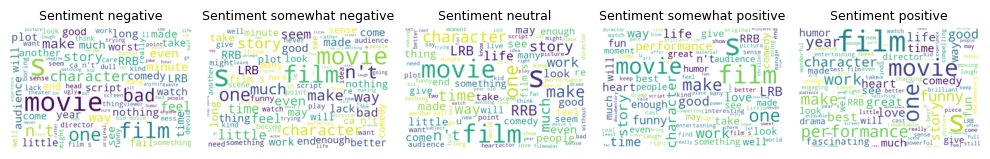

In [10]:
plt.style.use('default')
from wordcloud import WordCloud, STOPWORDS

fig, axs = plt.subplots(1, 5, figsize=(10, 12.5))

plt_idx = 0
for sentiment, d in df.groupby(df.Sentiment):
    sentiment_text = " ".join(d.Phrase.values.tolist())
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        width=600,
        height=400,
        background_color="white",
    ).generate(sentiment_text)
    axs = axs.flatten()
    axs[plt_idx].imshow(wordcloud, interpolation="bilinear")
    axs[plt_idx].set_title(f'Sentiment {sentiments_map[sentiment]}', fontsize=9)
    axs[plt_idx].axis("off")
    plt_idx += 1
plt.tight_layout()
plt.show()

# Model baseline

## Custom transformer for text cleaning and preprocessing

We implement a parametric function that allows to perform different pre-processing steps,
this will be used to validate the model against different pre-processing strategies. As basic cleaning step words are transformed in lowercase.

Implemented pre-processing operations:
* tokenization: standard english tokenizer in Spacy
* stopwords removal: english stopwords corpus in Spacy
* stemming: Porter's algorithm
* lemmatization: WordNet lemmatizer
* POS tagging: spacy implementation

In [15]:
from sklearn.base import TransformerMixin

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

def clean_text(text):
    return text.strip().lower()

In [16]:
import string
import spacy
from spacy.lang.en import English

import nltk

nlp = spacy.load("en_core_web_trf", disable=['ner', 'parser', 'lemmatizer', 'textcat'])
parser = English()

def stopwords_punctuation_removal(tokens):
    punctuations = string.punctuation
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    tokens = [token for token in tokens if token not in stopwords and token not in punctuations]
    return tokens

def stemming(tokens):
    porter = nltk.PorterStemmer()
    stems = [porter.stem(token) for token in tokens]
    return stems
    
def lemmatization(tokens):
    wordnet_lemmatizer = nltk.WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return lemmas
    
def spacy_tokenizer(phrase, steps=[]):
    tokens = parser(phrase)
    tokens = [token.text for token in tokens]
    
    for step in steps:
        tokens = step(tokens)
    
    return tokens

## Model definition

We define as baseline model a simple SVM classifier on the bag of words obtained computing tf-idf score of words

In [13]:
# useful modules
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [15]:
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)
classifier = svm.LinearSVC()
pipe = Pipeline([
    ('cleaner', predictors()),
    ('vectorizer', vectorizer),
    ('classifier', classifier)])

## Model validation
To validate the model we use a simple kfold strategy with 10 splits

We use accuracy as metric because it is the same metric autoamtically computed by kaggle on the test set.

In [16]:
# Generic function to perform cross validation on a given pipeline and a given set

def cross_validation(pipe, X, y, num_features=1, n_splits=10):
    kf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    if num_features > 1:    
        accuracy = 0
        for i, (train_index, val_index) in enumerate(kf.split(X, y)):
            pipe.fit(X.iloc[train_index], y[train_index])
            predicted = pipe.predict(X.iloc[val_index])
            current_accuracy = metrics.accuracy_score(y[val_index], predicted)
            print(f'Accuracy at fold {i}: {current_accuracy}')
            accuracy = accuracy + current_accuracy
        return accuracy / 10
    else:
        accuracy = 0
        for i, (train_index, val_index) in enumerate(kf.split(X, y)):
            pipe.fit(X[train_index], y[train_index])
            predicted = pipe.predict(X[val_index])
            current_accuracy = metrics.accuracy_score(y[val_index], predicted)
            print(f'Accuracy at fold {i}: {current_accuracy}')
            accuracy = accuracy + current_accuracy
        return accuracy / 10


In [17]:
X = df.Phrase
y = df.Sentiment

accuracy = cross_validation(pipe, X, y)
print(f'Accuracy: {accuracy}')

Accuracy at fold 0: 0.6518005895168525
Accuracy at fold 1: 0.644559784698193
Accuracy at fold 2: 0.644239395104447
Accuracy at fold 3: 0.6447520184544406
Accuracy at fold 4: 0.6489811610918877
Accuracy at fold 5: 0.6552607971293093
Accuracy at fold 6: 0.6441112392669486
Accuracy at fold 7: 0.6496219402793797
Accuracy at fold 8: 0.6517365115981033
Accuracy at fold 9: 0.6425733692169678
Accuracy: 0.6477636806356529


## Search across different preprocessing combinations

In [18]:
import time

preprocessing_steps_list = [
    [],
    [stopwords_punctuation_removal],
    [stopwords_punctuation_removal, stemming],
    [stopwords_punctuation_removal, lemmatization]
]

classifier = svm.LinearSVC()
results = {}
execution_times = {}
for i, preprocessing_steps in enumerate(preprocessing_steps_list):
    start_time = time.time()
    preprocessing_steps_names = [str(preprocessing_step) for preprocessing_step in preprocessing_steps]
    print(f'Preprocessings steps: {preprocessing_steps_names}')
    vectorizer = TfidfVectorizer(tokenizer = lambda phrase : spacy_tokenizer(phrase, preprocessing_steps))
    pipe = Pipeline([
        ('cleaner', predictors()),
        ('vectorizer', vectorizer),
        ('classifier', classifier)])
    results[i] = cross_validation(pipe, X, y)
    execution_time = time.time() - start_time
    execution_times[i] = execution_time
    print(f'Accuracy: {results[i]}')
    print(f'Execution time: {execution_time}')

Preprocessings steps: []
Accuracy at fold 0: 0.6518005895168525
Accuracy at fold 1: 0.644559784698193
Accuracy at fold 2: 0.644239395104447
Accuracy at fold 3: 0.6447520184544406
Accuracy at fold 4: 0.6489811610918877
Accuracy at fold 5: 0.6553248750480585
Accuracy at fold 6: 0.6441112392669486
Accuracy at fold 7: 0.6496219402793797
Accuracy at fold 8: 0.6517365115981033
Accuracy at fold 9: 0.6425733692169678
Accuracy: 0.6477700884275279
Execution time: 97.22829151153564
Preprocessings steps: ['<function stopwords_punctuation_removal at 0x0000021FEADF4B80>']
Accuracy at fold 0: 0.6430219146482122
Accuracy at fold 1: 0.6312956555171088
Accuracy at fold 2: 0.6351403306420608
Accuracy at fold 3: 0.6335383826733307
Accuracy at fold 4: 0.6393053953607587
Accuracy at fold 5: 0.6421889017044726
Accuracy at fold 6: 0.6359733435858004
Accuracy at fold 7: 0.6407791874919903
Accuracy at fold 8: 0.6410354991669871
Accuracy at fold 9: 0.6336024605920799
Accuracy: 0.6375881071382802
Execution time: 

In [19]:
print(results)
print(execution_times)

{0: 0.6477700884275279, 1: 0.6375881071382802, 2: 0.6302063308983724, 3: 0.6374535435089068}
{0: 97.22829151153564, 1: 90.33588290214539, 2: 224.10974669456482, 3: 118.67018103599548}


Another preprocessing to experiment with is POS tagging, for this operation we use an ad hoc implementation in which for efficiency reasons instead of using a function called by the sklearn vectorizer we have a preliminary tokenization defined using nlp.pipe() and list comprehension that are much faster than a standard iteration.
We explore two aspects of POS tagging:
* filtering words considering only adjective and adverbs that may be more informative about the sentiment of a phrase
* considering all the words concatenated with their tags

In [20]:
# tokens = pd.Series([[f'{token}_{token.pos_}' for token in doc if token.pos_ in ['ADJ', 'ADV']] 
#     for doc in nlp.pipe(df.Phrase.map(clean_text))])
# tokens.to_csv('./data/tokens_adj_adv_pos_tags.csv', index=False)

# The tagged tokens are imported from a serialized file because the pos tagging process for the whole dataset requires about 1 hour to run
tokens = pd.read_csv('./data/tokens_adj_adv_pos_tags.csv')['0']

In [21]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor = lambda x : x)
classifier = svm.LinearSVC()
pipe = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)])

X = tokens
y = df.Sentiment

accuracy = cross_validation(pipe, X, y)
print(f'Accuracy: {accuracy}')

Accuracy at fold 0: 0.5256952454184288
Accuracy at fold 1: 0.5217864923747276
Accuracy at fold 2: 0.5280661284121492
Accuracy at fold 3: 0.5253748558246828
Accuracy at fold 4: 0.5319748814558504
Accuracy at fold 5: 0.5307574009996155
Accuracy at fold 6: 0.5265923362809176
Accuracy at fold 7: 0.5278738946559016
Accuracy at fold 8: 0.525759323337178
Accuracy at fold 9: 0.5263360246059208
Accuracy: 0.5270216583365372


In [22]:
# tokens = pd.Series([[f'{token}_{token.pos_}' for token in doc] for doc in nlp.pipe(df.Phrase.map(clean_text))])
# tokens.to_csv('./data/tokens_all_pos_tags.csv', index=False)

tokens = pd.read_csv('./data/tokens_all_pos_tags.csv')['0']

In [23]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor = lambda x : x)
classifier = svm.LinearSVC()
pipe = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)])

X = tokens
y = df.Sentiment

accuracy = cross_validation(pipe, X, y)
print(f'Accuracy: {accuracy}')

Accuracy at fold 0: 0.5210175573497373
Accuracy at fold 1: 0.5195437652185056
Accuracy at fold 2: 0.5199282327310009
Accuracy at fold 3: 0.5207612456747405
Accuracy at fold 4: 0.5235806740997052
Accuracy at fold 5: 0.5191592977060105
Accuracy at fold 6: 0.51999231064975
Accuracy at fold 7: 0.5246059207996924
Accuracy at fold 8: 0.5205690119184929
Accuracy at fold 9: 0.5213379469434832
Accuracy: 0.521049596309112


## Include sentence id as a feature
As another attempt to improve the performances of the model we try some feature engineering, in particular we take into account the fact that phrases are part of a sentence by including the id of the sentence as a feature

In [24]:
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)
classifier = svm.LinearSVC()

sentence_id_transformer = FunctionTransformer(lambda x: x.SentenceId.values.reshape(-1, 1).shape)
phrase_transformer = FunctionTransformer(lambda x: x.Phrase.map(clean_text))

pipe = Pipeline([
    ('features', FeatureUnion([
        ('numeric_feature', sentence_id_transformer),
        ('text_features', Pipeline([
            ('selector', phrase_transformer),
            ('cleaner', predictors()), 
            ('vectorizer', vectorizer)]))])),
    ('classifier', classifier)])

In [25]:
X = df.iloc[:, 1:3]
y = df.Sentiment

accuracy = cross_validation(pipe, X, y, 2)
print(f'Accuracy: {accuracy}')

Accuracy at fold 0: 0.6518005895168525
Accuracy at fold 1: 0.644559784698193
Accuracy at fold 2: 0.644239395104447
Accuracy at fold 3: 0.6447520184544406
Accuracy at fold 4: 0.6489811610918877
Accuracy at fold 5: 0.6553248750480585
Accuracy at fold 6: 0.6441112392669486
Accuracy at fold 7: 0.6496219402793797
Accuracy at fold 8: 0.6517365115981033
Accuracy at fold 9: 0.6425733692169678
Accuracy: 0.6477700884275279


## Try to include other features
In addition to the text and the id of the sentence we try to define other features obtained by analyzing the relationship between sentences and phrases, so we try:
* start position of a phrase as percentage with respect to the length of the whole sentence 
* end position of a phrase as percentage with respect to the length of the whole sentence

The intuition is that different phrases in the same sentence can have different sentiment according to the position, for example in the beginning of the sentence a user may express more positive opinion and in the final part express his critics.

In [26]:
df['PhraseLength'] = df.Phrase.str.len()
df = df.sort_values(by='PhraseLength', ascending=False).reset_index(drop=True)

df['CompleteSentence'] = df.groupby(df.SentenceId).Phrase.transform('first')
df['PhraseStart'] = [x[0].find(x[1]) for x in zip(df.CompleteSentence, df.Phrase)]
df['PhraseEnd'] = [x[0].find(x[1]) + len(x[1]) for x in zip(df.CompleteSentence, df.Phrase)]
df['CompleteSentenceLength'] = df.CompleteSentence.str.len()
df['PhraseStartPercentage'] = df.PhraseStart / df.CompleteSentenceLength
df['PhraseEndPercentage'] = df.PhraseEnd / df.CompleteSentenceLength
df = df.drop(['PhraseStart', 'PhraseEnd', 'CompleteSentence', 'CompleteSentenceLength'], axis=1)
df_reduced = df.loc[df.PhraseStartPercentage >= 0].copy().reset_index(drop=True)

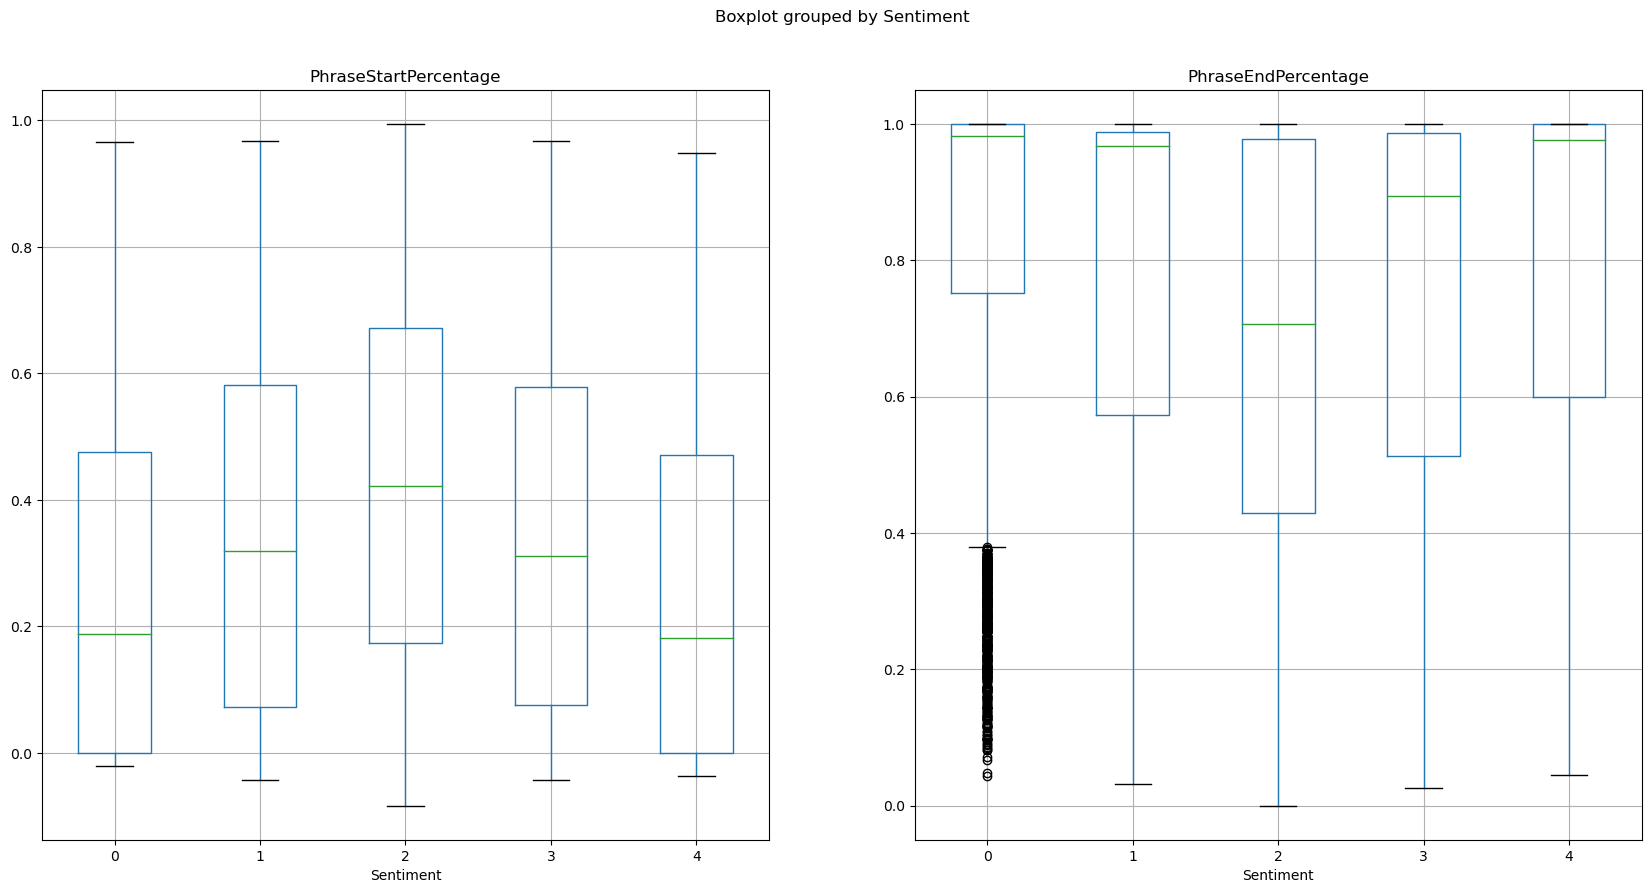

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
df.boxplot(by='Sentiment', column='PhraseStartPercentage', ax=axs[0])
df.boxplot(by='Sentiment', column='PhraseEndPercentage', ax=axs[1])
plt.show()

In [28]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)
classifier = svm.LinearSVC()
numerical_features = FunctionTransformer(lambda x: x[['PhraseStartPercentage', 'PhraseEndPercentage']])
phrase_transformer = FunctionTransformer(lambda x: x.Phrase.map(clean_text))

pipe = Pipeline([
    ('features', FeatureUnion([
        ('numerical_features', numerical_features),
        ('text_features', Pipeline([
            ('selector', phrase_transformer),
            ('cleaner', predictors()), 
            ('vectorizer', vectorizer)]))])),
    ('scaler', scaler),
    ('classifier', classifier)])

In [29]:
X = df[['Phrase', 'PhraseStartPercentage', 'PhraseEndPercentage']]
y = df.Sentiment

accuracy = cross_validation(pipe, X, y, 3)
print(f'Accuracy: {accuracy}')

Accuracy at fold 0: 0.6494937844418813
Accuracy at fold 1: 0.6481481481481481
Accuracy at fold 2: 0.6433423042419583
Accuracy at fold 3: 0.6436626938357042
Accuracy at fold 4: 0.6488530052543894
Accuracy at fold 5: 0.6410995770857363
Accuracy at fold 6: 0.6462258105856722
Accuracy at fold 7: 0.6450083301294374
Accuracy at fold 8: 0.6473151352044085
Accuracy at fold 9: 0.6466743560169166
Accuracy: 0.6459823144944251


## Search across different classifiers
After the choice of:
* the best preprocessing setting: no preprocessing
* the features: just the phrase

we explore different classification algorithms by performing an automatic search.

Runtime ~= 2 hours

In [ ]:
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)
classifiers = [
    MultinomialNB(),
    KNeighborsClassifier(),
    svm.LinearSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier()
]

X = df['Phrase']
y = df.Sentiment

results = {}
for i, classifier in enumerate(classifiers):
    print(f'classifier: {str(classifier)}')
    pipe = Pipeline([
        ('cleaner', predictors()),
        ('vectorizer', vectorizer),
        ('classifier', classifier)])

    results[i] = cross_validation(pipe, X, y, 3)

In [31]:
results

{0: 0.5896514161220043,
 1: 0.6156670511341793,
 2: 0.6477893118031527,
 3: 0.5084582852748942,
 4: 0.5937139561707034,
 5: 0.5404652056901191}

The best performance are obtained using linear SVC!

To get the most out of this classifier we perform an automatic grid search to choose the best hyperparameters values.

Runtime ~ 11 hours

In [ ]:
X = df['Phrase']
y = df.Sentiment

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__C': [1, 2, 5, 10],
    'classifier__dual': [True, False],
    'classifier__fit_intercept': [True, False],
    'classifier__tol': [5e-4, 2e-4, 1e-4],
    'classifier__class_weight': ['balanced', None]
}

kfold = StratifiedKFold(n_splits=10)
scoring = {'Accuracy': 'accuracy'}
refit = 'Accuracy'
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)
classifier = svm.LinearSVC()
pipe = Pipeline([
    ('cleaner', predictors()),
    ('vectorizer', vectorizer),
    ('classifier', classifier)])

svc_model = GridSearchCV(pipe, param_grid=param_grid, cv=kfold, scoring=scoring, refit=refit, n_jobs=1, return_train_score=True, verbose=10)
svc_model.fit(X, y)
svc_best = svc_model.best_estimator_

In [34]:
import pickle
with open("./models/svc/svc_best_params.pickle", "wb") as outfile:
	pickle.dump(svc_model.best_params_, outfile)

serialized results can be imported to avoid waiting for the grid search to complete.

In [17]:
import pickle
with open("./models/svc/svc_best_params.pickle", "rb") as infile:
	params = pickle.load(infile)

vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)
classifier = svm.LinearSVC()
params = {param_key.split('__')[1]: param_value for (param_key, param_value) in params.items()}
classifier.set_params(**params)

pipe = Pipeline([
    ('cleaner', predictors()),
    ('vectorizer', vectorizer),
    ('classifier', classifier)])

In [38]:
X = df.Phrase
y = df.Sentiment

accuracy = cross_validation(svc_best, X, y)
print(f'Accuracy: {accuracy}')

Accuracy at fold 0: 0.6515442778418556
Accuracy at fold 1: 0.6507112648981161
Accuracy at fold 2: 0.6466102780981674
Accuracy at fold 3: 0.6443034730231962
Accuracy at fold 4: 0.6483403819043957
Accuracy at fold 5: 0.6427015250544662
Accuracy at fold 6: 0.6469306676919133
Accuracy at fold 7: 0.6472510572856593
Accuracy at fold 8: 0.6500704857106241
Accuracy at fold 9: 0.6494297065231321
Accuracy: 0.6477893118031527


In [19]:
from tqdm import tqdm

X = df.Phrase
y = df.Sentiment

pipe.fit(X, y)
test_df = pd.read_csv(input_dir + 'test.tsv.zip', sep='\t')
test_df['Prediction'] = pipe.predict(test_df.Phrase)

In [21]:
submission = pd.DataFrame()
submission['PhraseId'] = test_df.PhraseId
submission['Sentiment'] = test_df.Prediction
submission.to_csv('./data/svc/submission.csv', index=False)

# XLNet
Trying to improve the results we explore a more complex, neural based, model.

The choice of this model is justified its performance on the dataset IMDb which is about the movie reviews domain analogously to this challenge.

We load a pratrained instance of the XLNet model, then we fine tune it for the specific task of sequence classification on the input dataset of movie reviews.

## Dataset loading and preparation

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict
from transformers import XLNetTokenizer, XLNetConfig, XLNetForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer

from datasets import load_metric

In [6]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
one_hot_columns = pd.DataFrame(one_hot_encoder.fit_transform(pd.DataFrame(df.Sentiment)))
one_hot_columns.index = df.index
df = df.drop('Sentiment', axis=1)
df['label'] = one_hot_columns.values.tolist()
df

,PhraseId,SentenceId,Phrase,label
0,1,1,A series of escapades demonstrating the adage ...,"[0.0, 1.0, 0.0, 0.0, 0.0]"
1,2,1,A series of escapades demonstrating the adage ...,"[0.0, 0.0, 1.0, 0.0, 0.0]"
2,3,1,A series,"[0.0, 0.0, 1.0, 0.0, 0.0]"
3,4,1,A,"[0.0, 0.0, 1.0, 0.0, 0.0]"
4,5,1,series,"[0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...,...,...
156055,156056,8544,Hearst 's,"[0.0, 0.0, 1.0, 0.0, 0.0]"
156056,156057,8544,forced avuncular chortles,"[0.0, 1.0, 0.0, 0.0, 0.0]"
156057,156058,8544,avuncular chortles,"[0.0, 0.0, 0.0, 1.0, 0.0]"
156058,156059,8544,avuncular,"[0.0, 0.0, 1.0, 0.0, 0.0]"


In [7]:
batch_size = 4
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', model_max_length=768)

def tokenize_function(examples):
    return tokenizer(examples['Phrase'], padding='max_length', truncation=True)

encoded_dataset = DatasetDict()

# use train test split in order to extract from the dataset a sample (size 1/10) with balanced sentiments
X = df.iloc[:, 1:-1]
y = df.label

_, sample, _, _ = train_test_split(X.index, y, stratify=y, test_size=0.1)
df_reduced = df.iloc[sample].reset_index().copy()

# split the reduced dataset in train and validation sets
X = df_reduced.iloc[:, 1:-1]
y = df_reduced.label
X_train, X_val, _, _ = train_test_split(X.index, y, stratify=y, test_size=0.2)
train_df_reduced = df_reduced.iloc[X_train]
val_df_reduced = df_reduced.iloc[X_val]

encoded_dataset['train'] = Dataset.from_pandas(train_df_reduced).map(tokenize_function, batched=True, batch_size=batch_size)
encoded_dataset['val'] = Dataset.from_pandas(val_df_reduced).map(tokenize_function, batched=True, batch_size=batch_size)

  0%|          | 0/3121 [00:00<?, ?ba/s]

  0%|          | 0/781 [00:00<?, ?ba/s]

In [8]:
encoded_dataset = encoded_dataset.remove_columns(['SentenceId', 'PhraseId', 'Phrase', '__index_level_0__'])

### Model definition and configuration

In [9]:
num_labels = 5

id2label = {
    0 : 'negative', 
    1 : 'somewhat negative',
    2 : 'neutral',
    3 : 'somewhat positive',
    4 : 'positive'
}

label2id = {
    'negative'          : 0, 
    'somewhat negative' : 1,
    'neutral'           : 2,
    'somewhat positive' : 3,
    'positive'          : 4
}

In [10]:
def model_init():
    config = XLNetConfig()
    model = XLNetForSequenceClassification(config).from_pretrained(
        "xlnet-base-cased", problem_type="multi_label_classification", num_labels=num_labels)
    model.config.id2label = id2label
    model.config.label2id = label2id

    return model

## Training setup

### Training parameters 

In [11]:
model_name = 'XLNet'
task = 'sentiment-analysis'
metric_name = 'accuracy'
batch_size = 4
training_args = TrainingArguments(
    f'{model_name}-finetuned-{task}',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name
)

### Metric declaration

In [12]:
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    labels = np.where(labels == 1)[1]
    return metric.compute(predictions=predictions, references=labels)

## Hyperparameter search
This process is performed on the 1 / 10 sample of the dataset.

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

best_run = trainer.hyperparameter_search(n_trials=10, direction='maximize')

In [ ]:
import pickle
with open("best_run.pickle", "wb") as outfile:
	pickle.dump(best_run, outfile)

The search of the hyperparameters involves several training epochs and evaluation of the model so it has a really long running time, the results are serialized and can be loaded in the following cells.

In [6]:
import pickle
with open("./models/XLNet-hp-tuning/best_run.pickle", "rb") as infile:
	best_run = pickle.load(infile)

In [7]:
for n, v in best_run.hyperparameters.items():
    if n != 'per_device_train_batch_size':
        print(n, v)

learning_rate 3.06941812255872e-05
num_train_epochs 3
seed 33


## Finetuning

Initialize the model with same settings as in the hp search and set hyperparameters values according to the best run.

In [ ]:
batch_size = 64
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', model_max_length=768)
def tokenize_function(examples):
    return tokenizer(examples['Phrase'], padding='max_length', truncation=True)

encoded_dataset = Dataset.from_pandas(df).map(tokenize_function, batched=True, batch_size=batch_size)

def model_init():
    config = XLNetConfig()
    model = XLNetForSequenceClassification(config).from_pretrained(
        "xlnet-base-cased", problem_type="multi_label_classification", num_labels=num_labels)
    model.config.id2label = id2label
    model.config.label2id = label2id

    return model

model_name = 'XLNetLarge'
task = 'sentiment-analysis'
metric_name = 'accuracy'
batch_size=4
training_args = TrainingArguments(
    f'{model_name}-finetuned-{task}',
    save_strategy = 'epoch',
    per_device_train_batch_size=batch_size,
    metric_for_best_model=metric_name
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=encoded_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

for n, v in best_run.hyperparameters.items():
    if n != 'per_device_train_batch_size':
        setattr(trainer.args, n, v)

trainer.train()

The training process is really long too, so the model was pushed to the hugging face hub, in the following cell the finetuned model can simply be downloaded and used for inference on the test set.

In [11]:
import torch

model = XLNetForSequenceClassification.from_pretrained('robb17/XLNet-finetuned-sentiment-analysis')
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

Downloading:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/448M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm

def classify(example):
    inputs = tokenizer(example, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits

    return logits.argmax().item()

tqdm.pandas()

test_df = pd.read_csv(input_dir + 'test.tsv.zip', sep='\t')
test_df['Prediction'] = test_df.Phrase.progress_map(classify)

In [ ]:
submission = pd.DataFrame()
submission['PhraseId'] = test_df.PhraseId
submission['Sentiment'] = test_df.Prediction
submission.to_csv('./data/XLNet/submission.csv', index=False)